## Import library

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time

# Arrhythmia Dataset

## Load data & explore

In [31]:
train_data = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv")
test_data = pd.read_csv("/kaggle/input/heartbeat/mitbih_test.csv")

In [32]:
print(f"Number of samples in train data: {train_data.shape[0]}")
print(f"Number of samples in test data: {test_data.shape[0]}")

Number of samples in train data: 87553
Number of samples in test data: 21891


In [33]:
train_data.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87,0.000000000000000000e+00.88
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Missing values

In [34]:
print(f"Missing values in train data: {train_data.isna().sum().sum()}")
print(f"Missing values in test data: {test_data.isna().sum().sum()}")

Missing values in train data: 0
Missing values in test data: 0


In [35]:
print(f"Duplicated values in train data: {train_data.duplicated().sum()}")
print(f"Duplicated values in test data: {test_data.duplicated().sum()}")

Duplicated values in train data: 0
Duplicated values in test data: 0


# Value count

Text(0, 0.5, 'Number of samples')

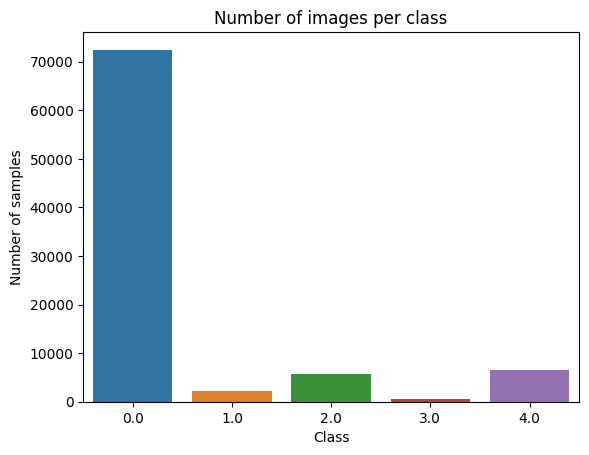

In [36]:
value_counts = train_data.iloc[:,-1].value_counts()
fig_train = sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of samples')

Text(0, 0.5, 'Number of samples')

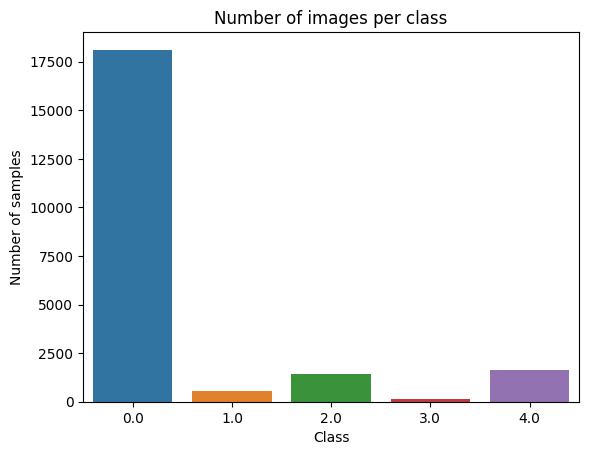

In [37]:
value_counts = test_data.iloc[:,-1].value_counts()
fig_test = sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of samples')

## Plot ECG

In [38]:
# Input labels
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

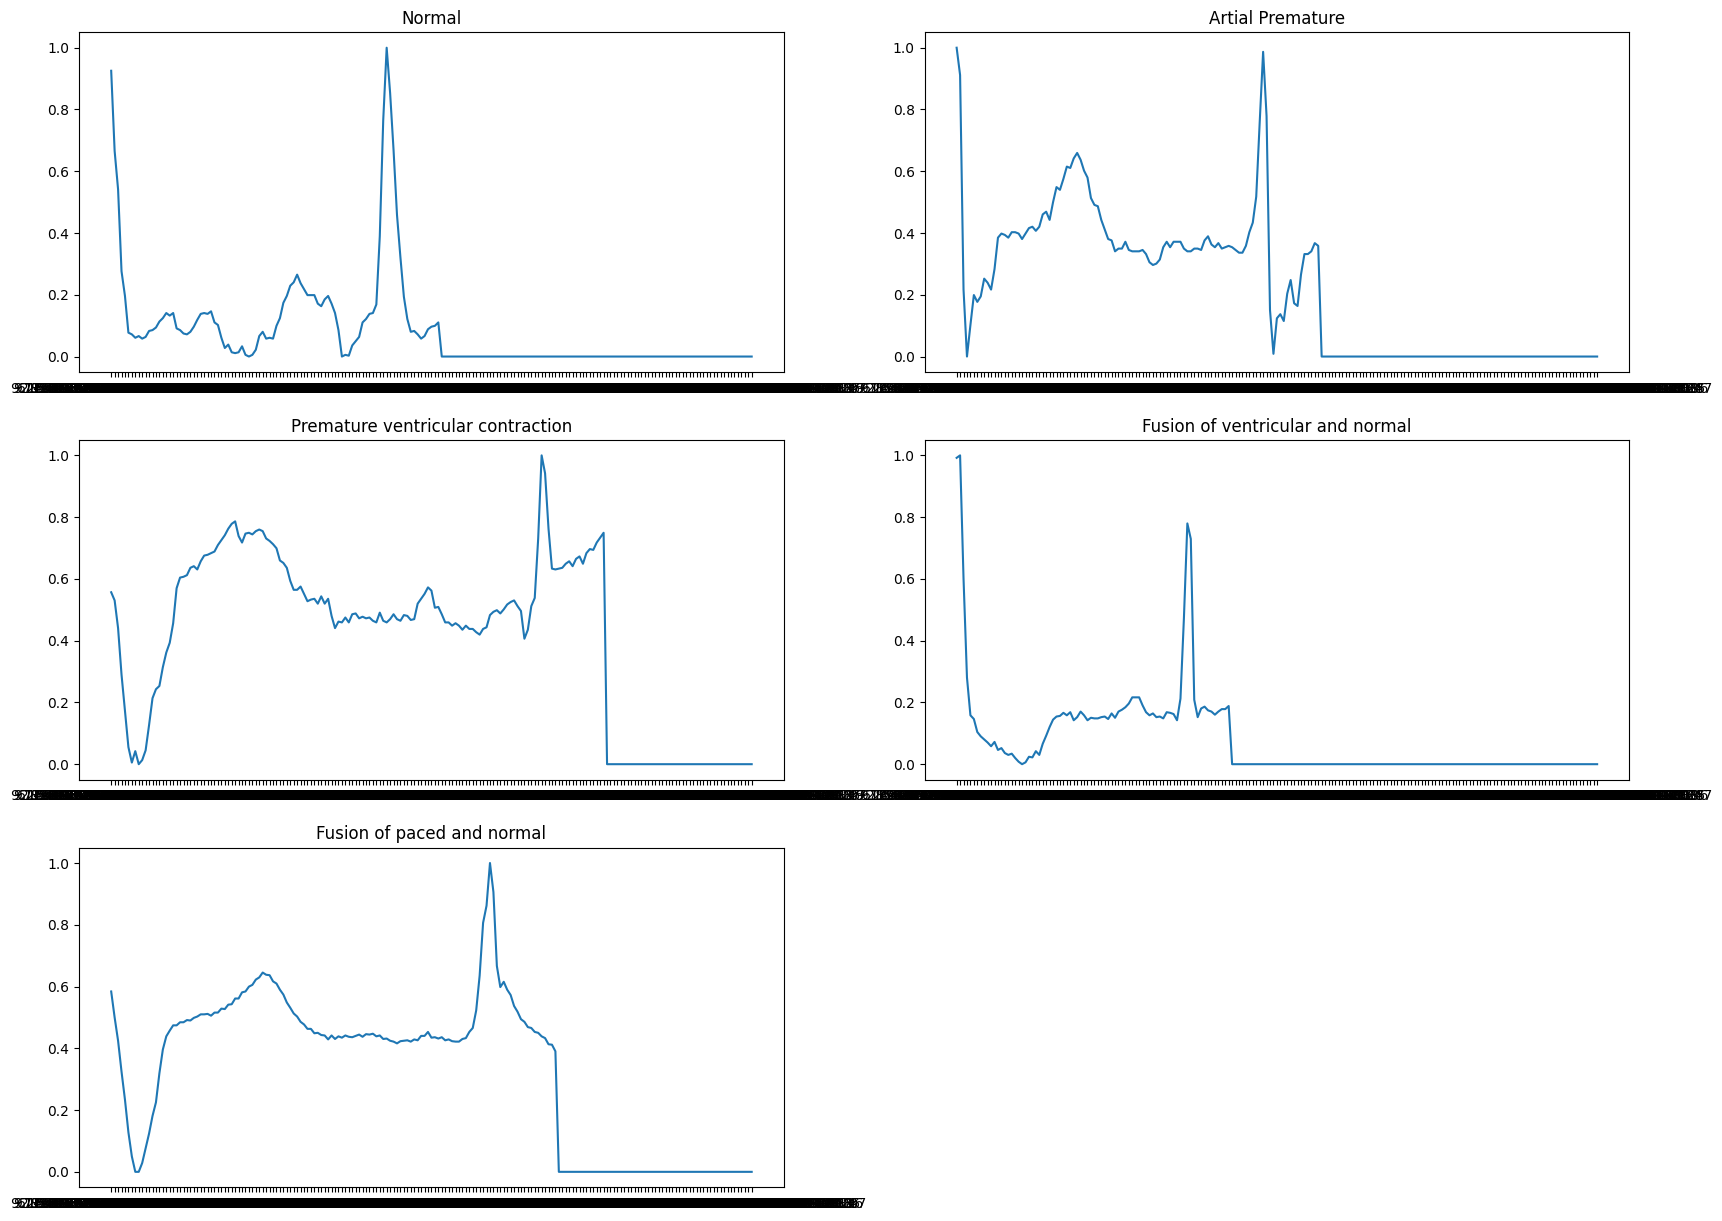

In [39]:
train_classes = train_data.iloc[:,-1].unique()

plt.figure(figsize=(20,15))

for idx, cls in enumerate(train_classes):
    plt.subplot(3,2,idx+1)
    plt.plot(train_data[train_data.iloc[:,-1]==cls].iloc[2,:-1])
    plt.title(labels[idx])

plt.show()

We can see that their is a time relationship in the x-axis, so it is my intention to use time series based model to process this data

## Define train and test dataset

In [40]:
ecg_train = train_data.iloc[:,:-1].values
label_train = train_data.iloc[:,-1].values
ecg_test = test_data.iloc[:,:-1].values
label_test = test_data.iloc[:,-1].values

print(ecg_train.shape, label_train.shape, ecg_test.shape, label_test.shape)

(87553, 187) (87553,) (21891, 187) (21891,)


In [41]:
# Scailing the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

scaler = MinMaxScaler()
ecg_train_scaled = scaler.fit_transform(ecg_train)
ecg_test_scaled = scaler.transform(ecg_test)

# Define the number of samples for the validation set based on the test data size
n_test_samples = ecg_test.shape[0]

# Split the training data into new training and validation sets
ecg_val, ecg_test, label_val, label_test = train_test_split(ecg_test_scaled, label_test, test_size=0.5, random_state=6, stratify=label_test)

# Reshape the data for LSTM (samples, timesteps, features)
ecg_train_scaled = np.reshape(ecg_train_scaled, (ecg_train_scaled.shape[0], ecg_train_scaled.shape[1]))
ecg_val = np.reshape(ecg_val, (ecg_val.shape[0], ecg_val.shape[1]))
ecg_test = np.reshape(ecg_test, (ecg_test.shape[0], ecg_test.shape[1]))


print(f"New Training set size: {ecg_train_scaled.shape[0]}")
print(f"Validation set size: {ecg_val.shape[0]}")
print(f"Test set size: {ecg_test.shape[0]}")

New Training set size: 87553
Validation set size: 10945
Test set size: 10946


In [42]:
print("Train shape: ", ecg_train_scaled.shape)
print("Label train shape: ", label_train.shape)

Train shape:  (87553, 187)
Label train shape:  (87553,)


In [43]:
ecg_train_scaled.dtype

dtype('float64')

## LSTM model

In [44]:
import torch
import torch.nn as nn

class LSTM_classification(nn.Module):
    def __init__(self):
        super(LSTM_classification, self).__init__()
        self.lstm1 = nn.LSTM(input_size=187, hidden_size=128, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(64, 5)
        
    def forward(self, x):
        x = x.unsqueeze(1) # for sequence_length 1
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1]
        x = self.fc(x)
        return x
        

In [45]:
model = LSTM_classification()
X_train_tensor = torch.randn(3, 187)
output = model(X_train_tensor)


In [46]:
print(output.shape)

torch.Size([3, 5])


# Train model LSTM
## Train variables

In [47]:
batch_size = 32
num_epochs = 20
validation_step = 5

## Load dataset

In [48]:
from torch.utils.data import DataLoader, TensorDataset

# Train
ecg_train_scaled = torch.tensor(ecg_train_scaled, dtype=torch.float32)
label_train = torch.tensor(label_train, dtype=torch.long).view(-1)
train_dataset = TensorDataset(ecg_train_scaled, label_train)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

# Val
ecg_val = torch.tensor(ecg_val, dtype=torch.float32)
label_val = torch.tensor(label_val, dtype=torch.long).view(-1)
val_dataset = TensorDataset(ecg_val, label_val)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

## Set model

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = LSTM_classification()
model.to(device)

Using device: cuda


LSTM_classification(
  (lstm1): LSTM(187, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

## Set optimizer & Loss function & Scheduler

In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-6, verbose=True)

In [51]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)  # Get predicted class
    correct = (preds == labels).float().sum()
    return correct / labels.size(0)

In [59]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += calculate_accuracy(outputs, targets).item()
    epoch_time = (time.time() - start_time) * 1000 / len(train_loader)

    train_loss = total_loss/len(train_loader)
    train_acc = total_acc/len(train_loader)
    
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    if (epoch+1) % validation_step == 0:
        
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs, y_val).item()

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} - "
              f"{epoch_time:.0f}ms/step - "
              f"accuracy: {train_acc:.4f} - "
              f"loss: {train_loss:.4f} - "
              # f"val_accuracy: {val_acc:.4f} - "
              # f"val_loss: {val_loss:.4f} - "
              f"learning_rate: {current_lr:.4f}")

print("Training complete...")
    

Epoch 1/20 - 4ms/step - accuracy: 0.9078 - loss: 0.3238 - learning_rate: 0.0010
Epoch 2/20 - 4ms/step - accuracy: 0.9157 - loss: 0.3015 - learning_rate: 0.0010
Epoch 3/20 - 4ms/step - accuracy: 0.9195 - loss: 0.2920 - learning_rate: 0.0010
Epoch 4/20 - 4ms/step - accuracy: 0.9212 - loss: 0.2899 - learning_rate: 0.0010
Epoch [5/20], Val Loss: 0.2541, Val Acc: 0.9237
Epoch 5/20 - 4ms/step - accuracy: 0.9217 - loss: 0.2855 - learning_rate: 0.0010
Epoch 6/20 - 4ms/step - accuracy: 0.9226 - loss: 0.2844 - learning_rate: 0.0010
Epoch 7/20 - 4ms/step - accuracy: 0.9234 - loss: 0.2825 - learning_rate: 0.0010
Epoch 8/20 - 4ms/step - accuracy: 0.9238 - loss: 0.2801 - learning_rate: 0.0010
Epoch 9/20 - 4ms/step - accuracy: 0.9244 - loss: 0.2799 - learning_rate: 0.0010
Epoch [10/20], Val Loss: 0.2434, Val Acc: 0.9280
Epoch 10/20 - 4ms/step - accuracy: 0.9262 - loss: 0.2750 - learning_rate: 0.0010
Epoch 11/20 - 4ms/step - accuracy: 0.9258 - loss: 0.2774 - learning_rate: 0.0010
Epoch 12/20 - 4ms/ste

In [ ]:
import torch
from transformers import PatchTSMixerConfig, PatchTSMixerForTimeSeriesClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model configuration
config = PatchTSMixerConfig(
    num_input_channels=1,  # Each sample has 187 features (single channel)
    num_targets=len(label_train.unique()),  # Number of classes
    context_length=187,  # ECG sample length
    patch_length=12,
    stride=12,
    use_cls_token=True,
)

# Initialize model
model = PatchTSMixerForTimeSeriesClassification(config=config).to(device)

# Convert ECG data to tensor and reshape
ecg_train_tensor = torch.tensor(ecg_train.values, dtype=torch.float32).unsqueeze(-1).to(device)  # Shape (87553, 187, 1)
label_train_tensor = torch.tensor(label_train.values, dtype=torch.long)  # Shape (87553,)

ecg_test_tensor = torch.tensor(ecg_test.values, dtype=torch.float32).unsqueeze(-1)  # Shape (21891, 187, 1)
label_test_tensor = torch.tensor(label_test.values, dtype=torch.long)  # Shape (21891,)

# Forward pass
outputs = model(past_values=ecg_train_tensor)
logits = outputs.prediction_logits  # Shape (batch_size, num_targets)

# Print shape of output
print(logits.shape)  # Should be (87553, num_targets)


In [ ]:
print(labels)